In [1]:
import sys
import os
import polars as pl
import numpy as np
# Add the project root directory to PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, project_root)

# Import necessary modules
import groundinsight as gi
from groundinsight.models.core_models import BusType, BranchType




In [2]:

#Test the calculation formula of the impedance
# Create a network
net = gi.create_network(name="MyTestNetwork", frequencies=[0, 50, 250, 350, 450, 550])
net.description = "That's my first test network"

bus_type = BusType(
    name="BusTypeFormulaTest",
    description="Example bus type with parameters",
    system_type="Grounded",
    voltage_level=230.0,
    impedance_formula="rho * 0 + 1 + I * f * 1/50",
)

bus_type_uw = BusType(
    name="BusTypeFormulaTestUW",
    description="Example bus type with parameters",
    system_type="Grounded",
    voltage_level=230.0,
    impedance_formula="rho * 0 + 0.1 + I * f * 1/50",
)

branch_type = BranchType(
    name="TestBranchType",
    description="A test branch type",
    grounding_conductor=True,
    self_impedance_formula="(rho * 0 + 0.25 + j * f * 0.012)*l",
    mutual_impedance_formula="(rho * 0 + 0.0 + j * f * 0.010)*l"
)

branch_ohl = BranchType(
    name="OHLine",
    description="An overhead line",
    grounding_conductor=False,
    self_impedance_formula="NaN",
    mutual_impedance_formula="NaN"
)

number_buses = 15
#create buses with a for loop
for i in range(1, number_buses):
    gi.create_bus(name=f"bus{i}", type=bus_type, network=net, specific_earth_resistance=100.0)


#create branch 
#defining a line length of each branch
line_length = 1

#create bracnches with a for loop
for i in range(1, number_buses-1):
    gi.create_branch(name=f"branch{i}", type=branch_type, from_bus=f"bus{i}", to_bus=f"bus{i+1}", length=line_length, specific_earth_resistance=100.0, network=net)


#net.add_bus(bus2, overwrite=True)

#create a faults
fault_scaling = {0:1, 50: 1.0, 250: 1}
faultnames = []
for i in range(1, number_buses):
    gi.create_fault(name=f"fault{i}", bus=f"bus{i}", description="A fault at bus {i}", scalings=fault_scaling, network=net)
    faultnames.append(f"fault{i}")



#add a source at bus1
source = gi.create_source(name="source1", bus="bus1", values={0:10, 50:60, 250:60, 350:60, 450:60, 550:60}, network=net)
#source2 = gi.create_source(name="source2", bus="bus6", values={0:0, 50:30, 250:30, 350:30}, network=net)

#define the paths of the network
gi.create_paths(network=net)

#for loop over each fault
for i in range(number_buses-1):
    # Run fault calculations
    gi.run_fault(net, fault_name=f"fault{i+1}")




# Access results
res_bus_df = net.res_buses(fault="fault8")
print(res_bus_df)
res_branch_df = net.res_branches(fault="fault8")

res_branch_branch1 = res_branch_df.filter(pl.col('branch_name') == 'branch2')
res_bus7 = res_bus_df.filter(pl.col('bus_name') == 'bus7')


# Access the reduction factors
result = net.results["fault12"]
reduction_factors = result.reduction_factor.value

# Access the grounding impedances
grounding_impedances = result.grounding_impedance.value

# Print reduction factors
for freq, rf in reduction_factors.items():
    print(f"Frequency: {freq} Hz, Reduction Factor: {rf}")

# Print the grounding impedances
for freq, z in grounding_impedances.items():
    try:
        print(f"Frequency: {freq} Hz, Grounding Impedance: {np.abs(z)}")
    except:
        print("Exception")







shape: (98, 7)
┌──────────┬────────┬──────────────┬───────────┬─────────────┬───────────┬──────────────┐
│ bus_name ┆ fault  ┆ frequency_Hz ┆ EPR_V     ┆ EPR_degree  ┆ I_bus_A   ┆ I_bus_degree │
│ ---      ┆ ---    ┆ ---          ┆ ---       ┆ ---         ┆ ---       ┆ ---          │
│ str      ┆ str    ┆ str          ┆ f64       ┆ f64         ┆ f64       ┆ f64          │
╞══════════╪════════╪══════════════╪═══════════╪═════════════╪═══════════╪══════════════╡
│ bus1     ┆ fault8 ┆ 0            ┆ 3.781552  ┆ 0.0         ┆ 3.781552  ┆ 0.0          │
│ bus1     ┆ fault8 ┆ 50           ┆ 17.065859 ┆ 7.485898    ┆ 12.067385 ┆ -37.514102   │
│ bus1     ┆ fault8 ┆ 250          ┆ 29.856348 ┆ 59.074023   ┆ 5.855312  ┆ -19.616045   │
│ bus1     ┆ fault8 ┆ 350          ┆ 39.47946  ┆ 67.195623   ┆ 5.583239  ┆ -14.674275   │
│ bus1     ┆ fault8 ┆ 450          ┆ 49.497134 ┆ 72.013849   ┆ 5.466044  ┆ -11.64596    │
│ …        ┆ …      ┆ …            ┆ …         ┆ …           ┆ …         ┆ …         

In [3]:
#print the impedance of all buses as dataframe
print(net.res_all_impedances())

shape: (84, 6)
┌────────────┬───────────┬──────────────┬───────────────────┬───────────────────┬──────────────────┐
│ fault_name ┆ fault_bus ┆ frequency_Hz ┆ grounding_impedan ┆ grounding_impedan ┆ reduction_factor │
│ ---        ┆ ---       ┆ ---          ┆ ce_Ohm            ┆ ce_deg            ┆ ---              │
│ str        ┆ str       ┆ f64          ┆ ---               ┆ ---               ┆ f64              │
│            ┆           ┆              ┆ f64               ┆ f64               ┆                  │
╞════════════╪═══════════╪══════════════╪═══════════════════╪═══════════════════╪══════════════════╡
│ fault1     ┆ bus1      ┆ 0.0          ┆ null              ┆ null              ┆ null             │
│ fault1     ┆ bus1      ┆ 50.0         ┆ null              ┆ null              ┆ null             │
│ fault1     ┆ bus1      ┆ 250.0        ┆ null              ┆ null              ┆ null             │
│ fault1     ┆ bus1      ┆ 350.0        ┆ null              ┆ null          

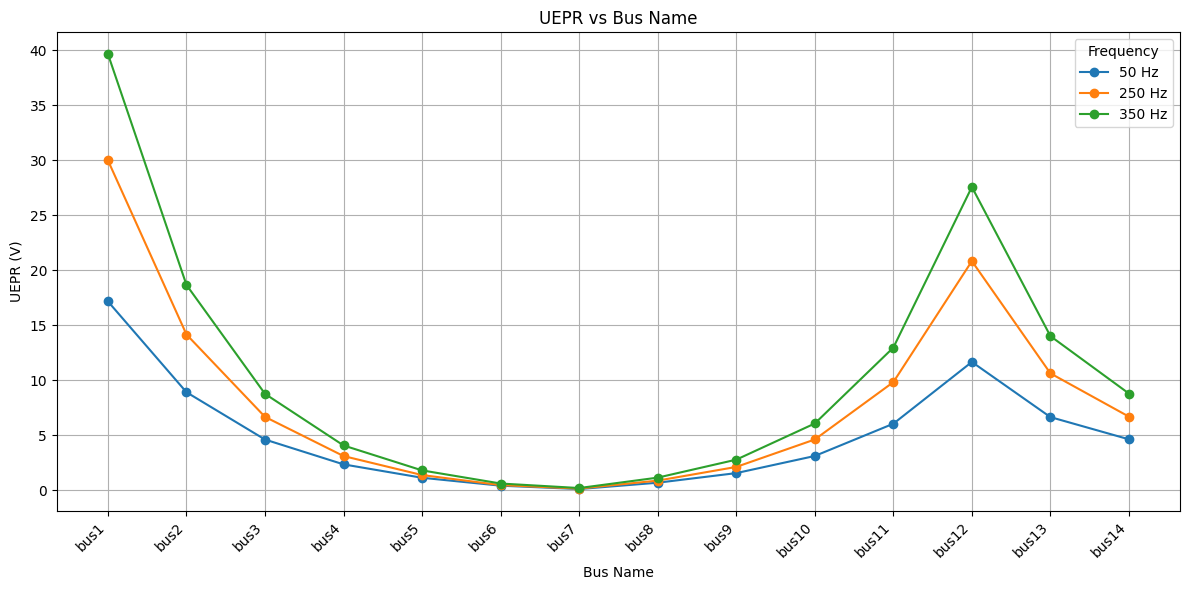

In [4]:
# Plot the results

gi.plot_bus_voltages(result=result, frequencies=[50, 250, 350], show=False);
#gi.plot_branch_currents(result=result)
#gi.plot_bus_currents(result=result)



#gi.plot_bus_voltages(result=result, frequencies=[50], show=False);